In [251]:
import librosa
import numpy as np
import tensorflow as tf
import soundfile as sf

In [252]:
# Load clean and noisy audio files
s, sr_s = librosa.load('train_clean_male.wav', sr=None)
sn, sr_sn = librosa.load('train_dirty_male.wav', sr=None)
t, sr_t = librosa.load('test_s_01.wav', sr=None)
tn, sr_tn = librosa.load('test_x_01.wav', sr=None)
i, sr_i = librosa.load('test_x_02.wav', sr=None)

# Set the STFT parameters
n_fft = 1024
hop_length = 512

# Compute the STFT and magnitude spectrograms
X = librosa.stft(sn, n_fft=n_fft, hop_length=hop_length)
S = librosa.stft(s, n_fft=n_fft, hop_length=hop_length)

TN = librosa.stft(tn, n_fft=n_fft, hop_length=hop_length)
T = librosa.stft(t, n_fft=n_fft, hop_length=hop_length)

I = librosa.stft(i, n_fft=n_fft, hop_length=hop_length)

# print the min, max of the arrays and the dtype
print(np.min(X), np.max(X), X.dtype, X.shape)
print(np.min(S), np.max(S), S.dtype, S.shape)

print(np.min(TN), np.max(TN), TN.dtype, TN.shape)
print(np.min(T), np.max(T), T.dtype, T.shape)

print(np.min(I), np.max(I), I.dtype, I.shape)


# Transpose the magnitude spectrograms
X_train = X.T
Y_train = S.T
X_test = TN.T
Y_test = T.T
X_input = I.T


# print the shape of the magnitude spectrograms
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print('X_input shape:', X_input.shape)

print('X Shape:', X.shape)
print('S Shape:', S.shape)
print('TN Shape:', TN.shape)
print('T Shape:', T.shape)
print('I Shape:', I.shape)

(-30.21952+9.251362j) (21.528316-6.439366j) complex64 (513, 2459)
(-30.195765+9.228826j) (21.51682-6.52095j) complex64 (513, 2459)
(-21.403784-3.3156915j) (22.47935+4.4695153j) complex64 (513, 142)
(-21.564178-3.344126j) (22.465538+4.424191j) complex64 (513, 142)
(-10.3424015+1.1153554j) (10.666173+1.1317672j) complex64 (513, 380)
X_train shape: (2459, 513)
Y_train shape: (2459, 513)
X_test shape: (142, 513)
Y_test shape: (142, 513)
X_input shape: (380, 513)
X Shape: (513, 2459)
S Shape: (513, 2459)
TN Shape: (513, 142)
T Shape: (513, 142)
I Shape: (513, 380)


In [253]:
# Define the speech enhancement model
def train_speech_enhancement_model(X_train_raw, Y_train_raw, X_test_raw, Y_test_raw, X_input_raw,
                                   layers=[512, 256, 128], activations=['relu', 'relu', 'relu'],
                                   output_activation='relu',
                                   epochs=50, optimizer='adam'):

    # Take the absolute value of the magnitude spectrograms
    Y_train_magnitude = np.abs(Y_train_raw)
    X_train_magnitude = np.abs(X_train_raw)
    Y_test_magnitude = np.abs(Y_test_raw)
    X_test_magnitude = np.abs(X_test_raw)
    X_input_magnitude = np.abs(X_input_raw)

    print('X_train :', X_train.shape, X_train.dtype)
    print('Y_train :', Y_train.shape, Y_train.dtype)
    print('X_test :', X_test.shape, X_test.dtype)
    print('Y_test :', Y_test.shape, Y_test.dtype)
    print('X_input :', X_input.shape, X_input.dtype)

    # normalize the magnitude spectrograms using standard scaler
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_magnitude)
    Y_train_scaled = scaler.transform(Y_train_magnitude)
    X_test_scaled = scaler.transform(X_test_magnitude)
    Y_test_scaled = scaler.transform(Y_test_magnitude)
    X_input_scaled = scaler.transform(X_input_magnitude)

    # Define the SNR loss function
    def snr_loss_fn(y_true, y_pred):
        # Compute the signal power (sum of squares of the true signal)
        signal_power = tf.reduce_sum(tf.square(y_true), axis=-1)

        # Compute the noise power (sum of squares of the difference between true and predicted signal)
        noise_power = tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)

        # Add a small epsilon to avoid division by zero
        epsilon = 1e-20

        # Calculate the SNR (in dB)
        snr = 10 * tf.math.log(signal_power / (noise_power + epsilon)) / tf.math.log(10.0)

        # Return the negative SNR as the loss
        return -tf.reduce_mean(snr)


    # Ensure input shape for the model
    input_shape = 513
    print(X_train.shape[1])
    # Build the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))
    for units, activation in zip(layers, activations):
        model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(input_shape, activation=output_activation))

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=[snr_loss_fn])

    # Train the model
    history = model.fit(X_train_scaled, Y_train_scaled, epochs=epochs, validation_data=(X_test_scaled, Y_test_scaled))

    # Test the model on the test dataset
    X_output = model.predict(X_test_scaled)

    # Inverse transform the scaled magnitude spectrograms
    Y_output_magnitude = scaler.inverse_transform(X_output)

    # Compute the SNR on the test dataset
    signal_power = np.sum(np.square(Y_test_magnitude), axis=-1)
    noise_power = np.sum(np.square(Y_test_magnitude - Y_output_magnitude), axis=-1)
    snr = np.mean(10 * np.log10(signal_power / noise_power))

    # recapture the original phase information
    Y_output = Y_output_magnitude * Y_test_raw / Y_test_magnitude

    def plot_spectrograms(original, noisy, enhanced, sr, hop_length):
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))

        # Plot original clean audio spectrogram
        ax = axes[0]
        S_dB = librosa.amplitude_to_db(np.abs(original), ref=np.max)
        img = librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax)
        ax.set_title('Original Clean Spectrogram')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        # Plot noisy audio spectrogram
        ax = axes[1]
        X_dB = librosa.amplitude_to_db(np.abs(noisy), ref=np.max)
        img = librosa.display.specshow(X_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax)
        ax.set_title('Noisy Spectrogram')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        # Plot enhanced audio spectrogram
        ax = axes[2]
        Y_dB = librosa.amplitude_to_db(np.abs(enhanced), ref=np.max)
        img = librosa.display.specshow(Y_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax)
        ax.set_title('Enhanced Spectrogram')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        plt.tight_layout()
        plt.show()

        # Plot original clean audio spectrogram
    plot_spectrograms(T, TN, Y_out, sr_t, hop_length)

    # Inverse STFT to obtain the enhanced audio
    Y_output = librosa.istft(Y_output.T, hop_length=hop_length)

    # Return the model and prediction results
    return model, Y_output, history, snr


In [254]:
import itertools
import matplotlib.pyplot as plt

# Define the grid search function
def grid_search_snr(X_train, Y_train, X_test, Y_test, X_input, param_grid):

    param_combinations = list(itertools.product(*param_grid.values()))
    histories = []
    Y_outputs = []
    models = []
    snrs = []

    # Perform grid search
    for param_combination in param_combinations:
        params = {key: value for key, value in zip(param_grid.keys(), param_combination)}

        print(f"Training with parameters: {params}")  # Print the current parameter combination

        # Train the model with the current parameter combination
        model, Y_output, history, snr = train_speech_enhancement_model(
            X_train, Y_train, X_test, Y_test, X_input,
            layers=params['layers'],
            activations=params['activations'],
            output_activation=params['output_activation'],
            epochs=params['epochs'],
            optimizer=params['optimizer']
        )

        # Store the result
        histories.append({
            'params': params,
            'history': history
        })

        Y_outputs.append({
            'params': params,
            'Y_output': Y_output,
            'snr': snr
        })

        models.append({
            'params': params,
            'model': model
        })

        snrs.append({
            'params': params,
            'snr': snr
        })

    return models, Y_outputs, histories, snrs

In [255]:
from google.colab import drive
import soundfile as sf
import os

# Mount the Google Drive
drive.mount('/content/drive')

def save_y_outputs(Y_outputs, sr):
    # Define the path in Google Drive
    drive_path = '/content/drive/My Drive/Colab_Audio_Files'
    os.makedirs(drive_path, exist_ok=True)  # Ensure the directory exists

    # Loop through each output dict in Y_outputs
    for idx, output_dict in enumerate(Y_outputs):
        params = output_dict['params']  # Extract parameters
        Y_output = output_dict['Y_output']  # Extract audio data
        snr = output_dict['snr']  # Extract SNR

        # Construct the filename safely
        filename = f"{params['layers']}_{params['activations']}_{params['epochs']}_[{snr}].wav"

        # Define the full path for the file
        full_path = os.path.join(drive_path, filename)

        # Save the audio file
        sf.write(full_path, Y_output, sr)

        # Print confirmation
        print(f"Saved {full_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [256]:
def plot_losses(histories, snrs):
    plt.figure(figsize=(10, 6))

    # Iterate through each model's history and label based on params and SNR value
    for history_info, snr_info in zip(histories, snrs):
        params = history_info['params']  # Extract model parameters
        snr = snr_info['snr']  # Extract SNR value
        history = history_info['history']  # Extract training history

        # Create a label that includes parameters and SNR value
        label = f"Params: {params}, SNR: {snr:.2f} dB"

        # Plot validation loss
        plt.plot(history.history['val_loss'], label=label)

    plt.title('Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=1)
    plt.grid(True)
    plt.show()

In [257]:
import pandas as pd
def snr_table(snrs):

    # print the SNR values in a dataframe
    snr_df = pd.DataFrame(snrs)
    snr_df = snr_df.sort_values(by='snr', ascending=False)
    print(snr_df)


Testing

In [258]:
# Define the parameter grid
param_grid = {
    'layers': [[128, 64, 32, 16]],
    'activations': [['relu', 'relu', 'relu', 'relu']],
    'output_activation': ['softplus'],
    'epochs': [4],  # Shorter epochs for grid search
    'optimizer': ['adam']
}

Training with parameters: {'layers': [128, 64, 32, 16], 'activations': ['relu', 'relu', 'relu', 'relu'], 'output_activation': 'softplus', 'epochs': 4, 'optimizer': 'adam'}
X_train : (2459, 513) float32
Y_train : (2459, 513) float32
X_test : (142, 513) float32
Y_test : (142, 513) float32
X_input : (142, 513) float32
513
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4739 - snr_loss_fn: 49.7421 - val_loss: 0.4598 - val_snr_loss_fn: 49.4239
Epoch 2/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4592 - snr_loss_fn: 49.4422 - val_loss: 0.4448 - val_snr_loss_fn: 49.2797
Epoch 3/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4437 - snr_loss_fn: 50.2053 - val_loss: 0.4260 - val_snr_loss_fn: 49.0921
Epoch 4/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4214 - snr_loss_fn: 49.0955 - val_loss: 0.3840 - val_snr_loss_fn: 48.6415
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
model Y_out: 0.48915008 0.7699045 float32 (142, 513)
model Y_out after denormalisation: 15.444718 24.309427 float32 (142, 513)
basis: (-1-0.0003990711j) (1+0.00030144077j) complex64 (142, 513)
Y_out after scaling: (-24.137556+1.9132847j) (24.219906-0.7165701j) complex64 (513, 142)
Y_output: -9.639614 9.665481 float32 (72192,)


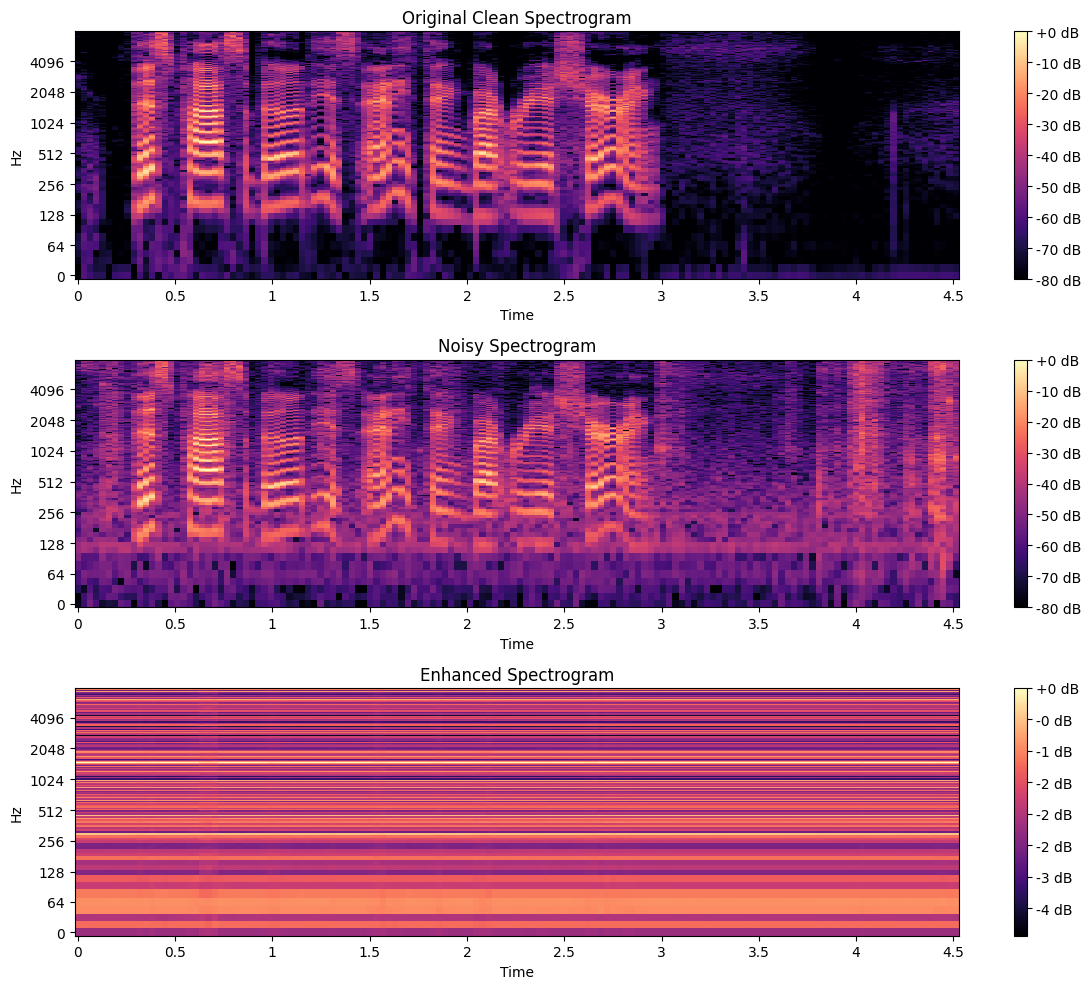

In [259]:
models, Y_outputs, histories, snrs = grid_search_snr(X_train, Y_train, X_test, Y_test, X_test, param_grid)

Saved /content/drive/My Drive/Colab_Audio_Files/[128, 64, 32, 16]_['relu', 'relu', 'relu', 'relu']_4_[-39.184425354003906].wav


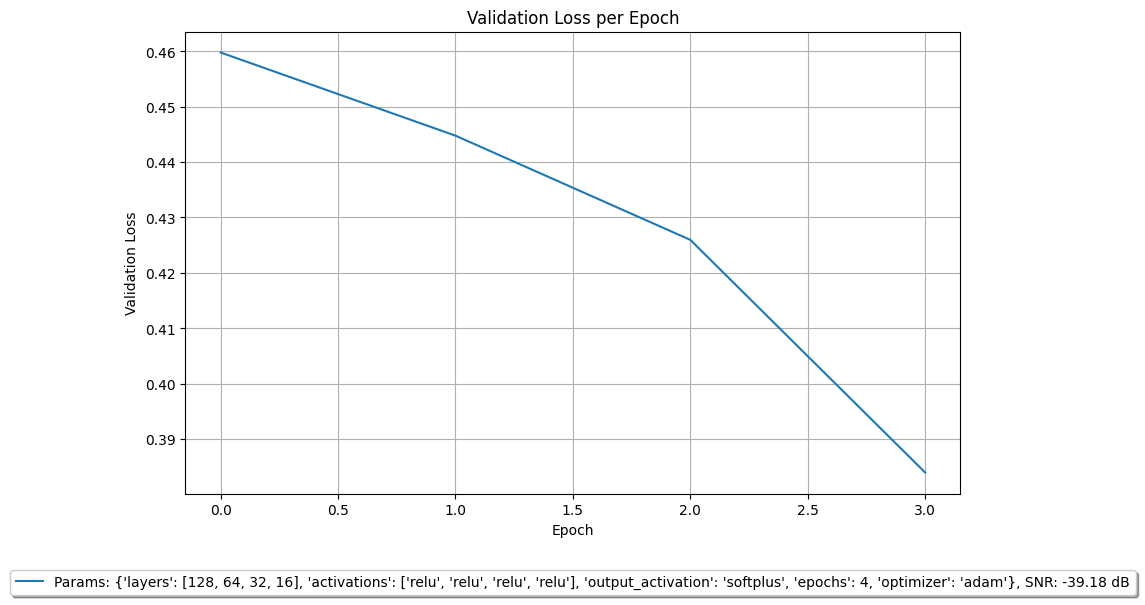

                                              params        snr
0  {'layers': [128, 64, 32, 16], 'activations': [... -39.184425


In [260]:
save_y_outputs(Y_outputs, sr_tn)
plot_losses(histories, snrs)
snr_table(snrs)

In [264]:
from tensorflow.keras.optimizers import SGD

# Define the parameter grid
param_grid = {
    'layers': [[128, 64, 32, 16]],
    'activations': [['tanh', 'tanh', 'tanh', 'tanh'], ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], ['relu', 'relu', 'relu', 'relu'], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']],
    'output_activation': ['sigmoid'],
    'epochs': [40],  # Shorter epochs for grid search
    'optimizer': [SGD(learning_rate=0.1)]
}

Training with parameters: {'layers': [128, 64, 32, 16], 'activations': ['tanh', 'tanh', 'tanh', 'tanh'], 'output_activation': 'sigmoid', 'epochs': 40, 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x7b8b43613970>}
X_train : (2459, 513) float32
Y_train : (2459, 513) float32
X_test : (142, 513) float32
Y_test : (142, 513) float32
X_input : (142, 513) float32
513
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2474 - snr_loss_fn: 47.6176 - val_loss: 0.2433 - val_snr_loss_fn: 46.6593
Epoch 2/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2449 - snr_loss_fn: 47.3592 - val_loss: 0.2404 - val_snr_loss_fn: 46.6073
Epoch 3/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2417 - snr_loss_fn: 47.1567 - val_loss: 0.2363 - val_snr_loss_fn: 46.5323
Epoch 4/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2370 - snr_loss_fn: 47.2884 - val_loss: 0.2296 - val_snr_loss_fn: 46.4078
Epoch 5/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2295 - snr_loss_fn: 46.9421 - val_loss: 0.2191 - val_snr_loss_fn: 46.2047
Epoch 6/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2179 - snr_loss_fn: 46.7537 - val_loss: 0.2049 - val_snr_loss_fn: 45.9133
Epoch 7/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2028 - snr_loss_fn: 45.8763 - val_loss: 0.1883 - val_snr_loss_fn: 45.5461
Epoch 8/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

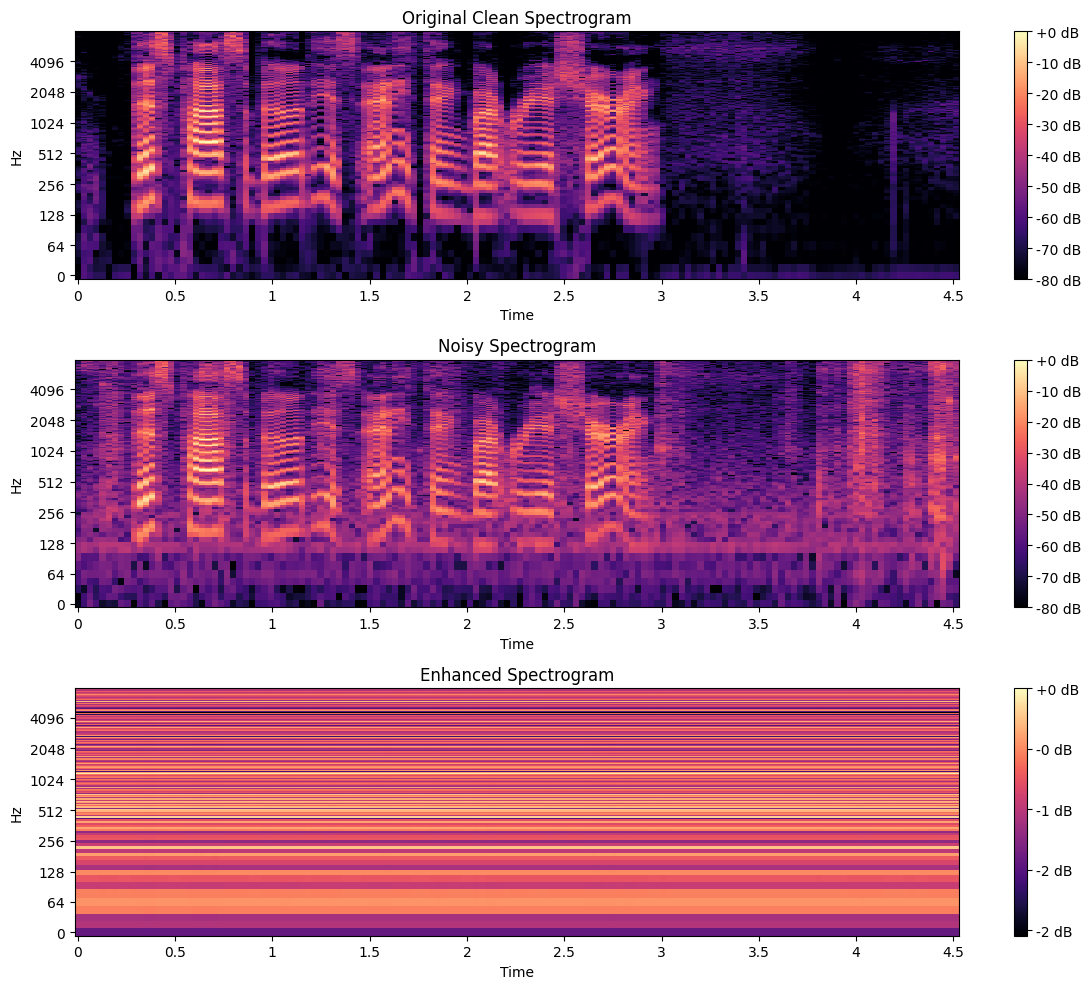

Training with parameters: {'layers': [128, 64, 32, 16], 'activations': ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], 'output_activation': 'sigmoid', 'epochs': 40, 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x7b8b43613970>}
X_train : (2459, 513) float32
Y_train : (2459, 513) float32
X_test : (142, 513) float32
Y_test : (142, 513) float32
X_input : (142, 513) float32
513
Epoch 1/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2465 - snr_loss_fn: 47.0870 - val_loss: 0.2366 - val_snr_loss_fn: 46.5378
Epoch 2/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2361 - snr_loss_fn: 46.9840 - val_loss: 0.2263 - val_snr_loss_fn: 46.3444
Epoch 3/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2257 - snr_loss_fn: 46.6196 - val_loss: 0.2156 - val_snr_loss_fn: 46.1350
Epoch 4/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2149 - snr_loss_fn: 46.6734 - val_loss: 0.2043 - val_snr_loss_fn: 45.9015
Epoch 5/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2034 - snr_l

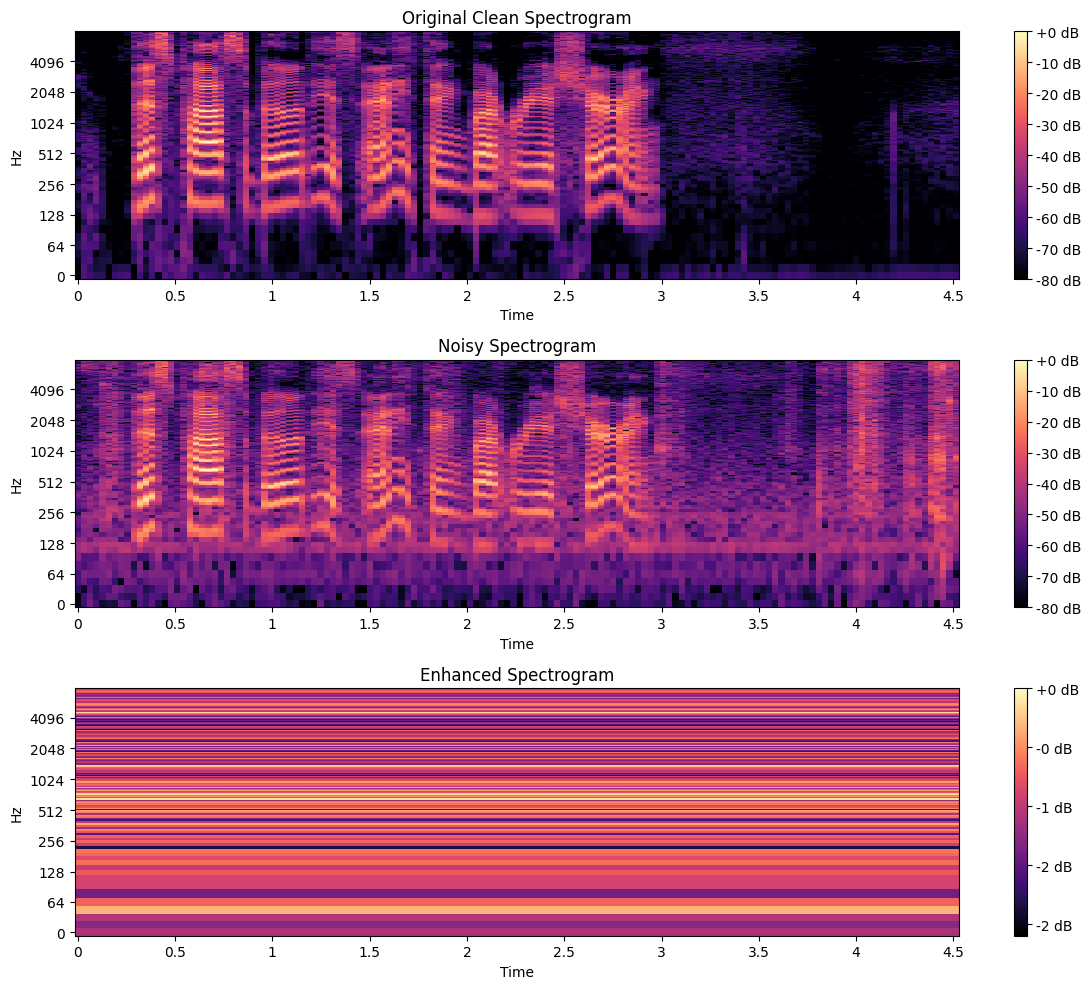

Training with parameters: {'layers': [128, 64, 32, 16], 'activations': ['relu', 'relu', 'relu', 'relu'], 'output_activation': 'sigmoid', 'epochs': 40, 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x7b8b43613970>}
X_train : (2459, 513) float32
Y_train : (2459, 513) float32
X_test : (142, 513) float32
Y_test : (142, 513) float32
X_input : (142, 513) float32
513
Epoch 1/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2475 - snr_loss_fn: 47.4502 - val_loss: 0.2438 - val_snr_loss_fn: 46.6683
Epoch 2/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2455 - snr_loss_fn: 46.9050 - val_loss: 0.2418 - val_snr_loss_fn: 46.6326
Epoch 3/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2434 - snr_loss_fn: 46.7418 - val_loss: 0.2397 - val_snr_loss_fn: 46.5952
Epoch 4/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2413 - snr_loss_fn: 46.9216 - val_loss: 0.2375 - val_snr_loss_fn: 46.5546
Epoch 5/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2391 - snr_loss_fn: 46.8

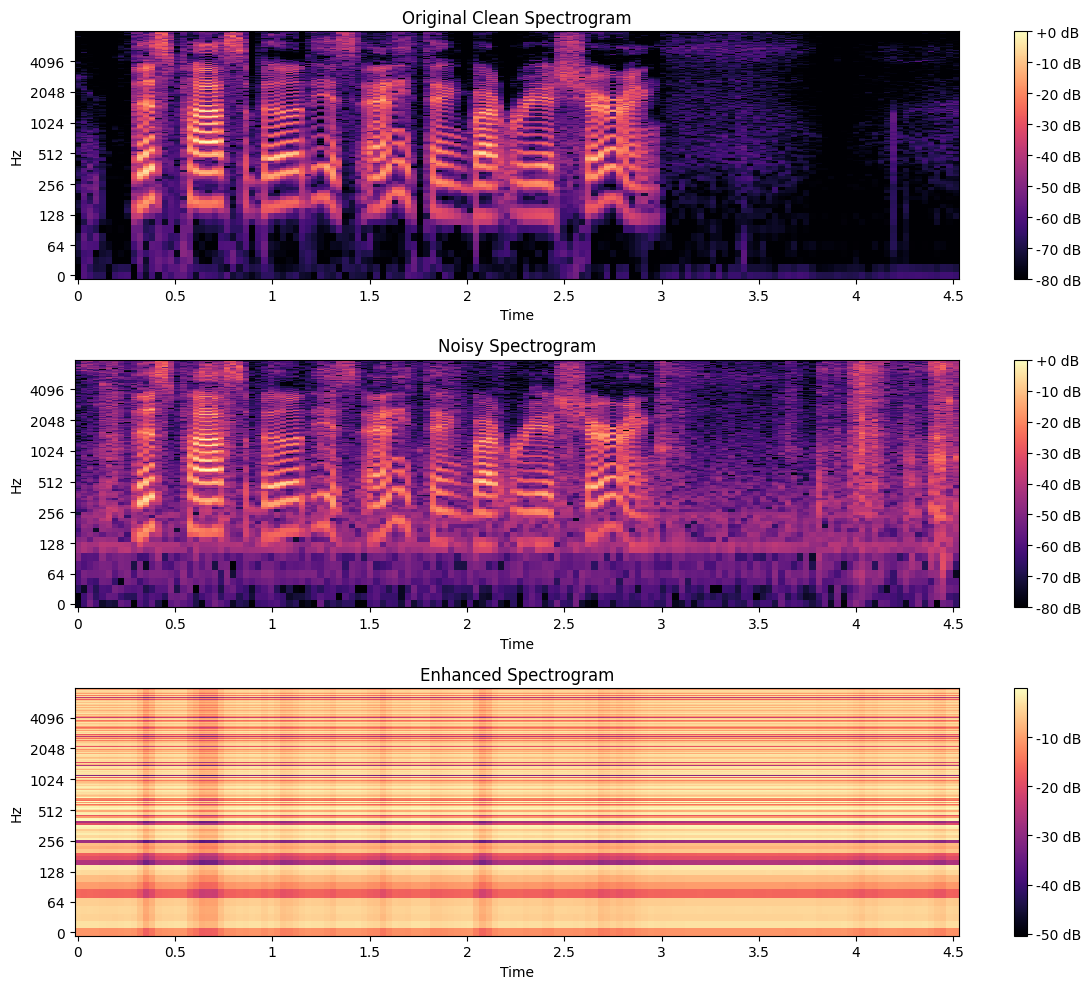

Training with parameters: {'layers': [128, 64, 32, 16], 'activations': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'output_activation': 'sigmoid', 'epochs': 40, 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x7b8b43613970>}
X_train : (2459, 513) float32
Y_train : (2459, 513) float32
X_test : (142, 513) float32
Y_test : (142, 513) float32
X_input : (142, 513) float32
513
Epoch 1/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2475 - snr_loss_fn: 47.4622 - val_loss: 0.2438 - val_snr_loss_fn: 46.6694
Epoch 2/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2456 - snr_loss_fn: 47.4859 - val_loss: 0.2419 - val_snr_loss_fn: 46.6348
Epoch 3/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2436 - snr_loss_fn: 47.0430 - val_loss: 0.2399 - val_snr_loss_fn: 46.5992
Epoch 4/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2416 - snr_loss_fn: 47.6000 - val_loss: 0.2379 - val_snr_loss_fn: 46.5619
Epoch 5/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0

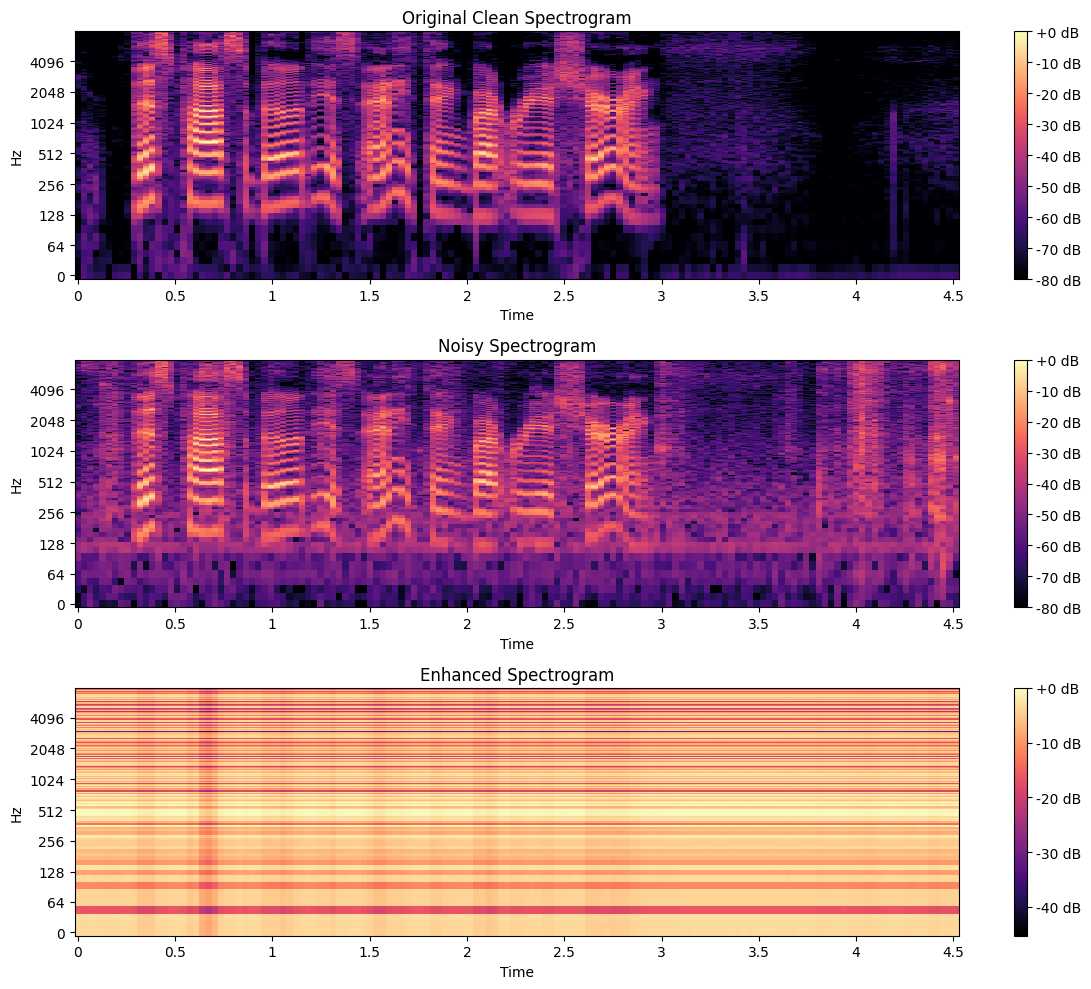

In [265]:
models, Y_outputs, histories, snrs = grid_search_snr(X_train, Y_train, X_test, Y_test, X_test, param_grid)

Saved /content/drive/My Drive/Colab_Audio_Files/[128, 64, 32, 16]_['tanh', 'tanh', 'tanh', 'tanh']_40_[-26.631322860717773].wav
Saved /content/drive/My Drive/Colab_Audio_Files/[128, 64, 32, 16]_['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']_40_[-26.55959701538086].wav
Saved /content/drive/My Drive/Colab_Audio_Files/[128, 64, 32, 16]_['relu', 'relu', 'relu', 'relu']_40_[-3.861612319946289].wav
Saved /content/drive/My Drive/Colab_Audio_Files/[128, 64, 32, 16]_['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']_40_[-3.9765844345092773].wav


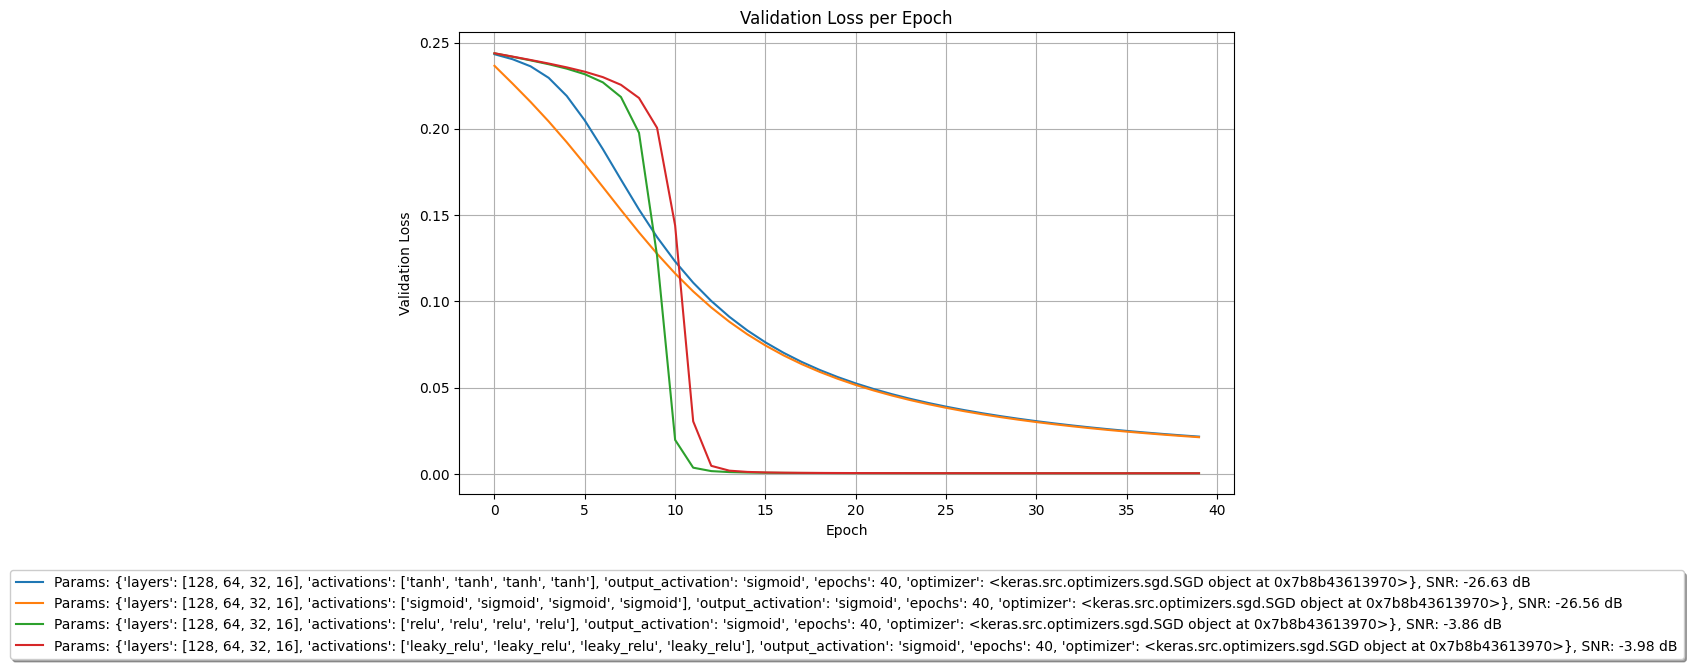

                                              params        snr
2  {'layers': [128, 64, 32, 16], 'activations': [...  -3.861612
3  {'layers': [128, 64, 32, 16], 'activations': [...  -3.976584
1  {'layers': [128, 64, 32, 16], 'activations': [... -26.559597
0  {'layers': [128, 64, 32, 16], 'activations': [... -26.631323


In [266]:
save_y_outputs(Y_outputs, sr_tn)
plot_losses(histories, snrs)
snr_table(snrs)